# 🚀 Tutorial: Constrained Optimal Transport with OTT-JAX


# Part 1 – Introduction
This tutorial explores how to solve **Optimal Transport (OT)** problems under linear constraints using the **OTT-JAX** library, a fast and flexible toolbox built on top of [JAX](https://github.com/google/jax) for differentiable optimal transport computations.

We will reproduce and explore multiple algorithms described in the paper:

> **"Constrained Optimal Transport with Soft Marginals and Linear Constraints"**  
> *Tang, Le Gouic, Solomon, et al., 2024*

These algorithms address problems of the form:

- Given input **marginals** $r, c$, a **cost matrix** $C$, and **additional linear constraints** on the transport matrix $P$,
- Find a plan $P$ that approximately minimizes the **entropic optimal transport objective**, while matching the marginals and satisfying the constraints.

---

### What You'll Learn

By the end of this tutorial, you’ll understand:

- How to solve constrained OT problems using **Sinkhorn-type algorithms**.
- How to accelerate convergence using **Newton methods** and **entropy scheduling**.
- How to benchmark algorithms using metrics like **cost gap**, **constraint violation**, and **TV distance**.

---

### Algorithms Covered

1. **Algorithm 1**: Sinkhorn under linear constraints  
2. **Algorithm 2**: Sinkhorn-Newton-Sparse (SNS)  
3. **Algorithm 3**: Entropy-regularization scheduling  

We will accompany each method with **plots and convergence diagnostics**, so you can visualize their performance.

---

Let’s begin by setting up the environment and problem!

# Part 2 – Setup and Installation

Before diving into the algorithms, we need to make sure the required libraries are installed and properly imported.

---

### Install Dependencies

This tutorial requires the following Python packages:

- `jax`, `jaxlib`: For high-performance automatic differentiation and GPU/TPU support.
- `ott-jax`: The main library for optimal transport.
- `matplotlib`: For plotting results.
- `jaxopt`: For efficient optimization routines.
- `numpy`: For general numerical utilities.

To install them, run the following in a cell or terminal:

In [2]:
!pip install jax jaxlib ott-jax matplotlib jaxopt numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.6 MB/s eta 0:00:00


### Import Modules
We will be using the following imports throughout the notebook:

In [3]:
import time
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from ott.geometry import geometry as geom
from jaxopt import linear_solve
from time import perf_counter

# 📌 Part 3 – Problem Setup

In this section, we define the problem of interest: a constrained entropic optimal transport problem.

---

### Objective

We want to compute a transport matrix $P \in \mathbb{R}_{\geq 0}^{n \times n}$ that:

- **Matches marginals**:  
  $$
  P \mathbf{1} = r, \quad P^\top \mathbf{1} = c
  $$

- **Satisfies extra linear constraints**:
  $$
  \langle D_k, P \rangle \begin{cases}
  \geq 0 & \text{for } k = 1, \ldots, K \quad \text{(inequality constraints)} \\
  = 0 & \text{for } k = K+1, \ldots, K+L \quad \text{(equality constraints)}
  \end{cases}
  $$

- **Minimizes the entropic optimal transport objective**:
  $$
  \min_{P \geq 0} \; \langle C, P \rangle + \frac{1}{\eta} \mathrm{KL}(P \| \mathbf{1})
  $$

where $C$ is the cost matrix and $\eta > 0$ is the entropic regularization strength.

---

### Synthetic Data Generation

We will work with synthetic data for reproducibility and benchmarking:

- **Cost matrix** $C$: sampled from $\mathcal{U}[0, 1]^{n \times n}$
- **Marginals** $r, c$: uniform vectors
- **Constraint matrices** $D_1$, $D_2$: sampled and centered to represent:
  - one inequality constraint ($\geq 0$)
  - one equality constraint ($= 0$)

---

### Parameters

We will use:

- $n = 500$: size of the transport plan  
- $\eta = 1200.0$: entropic regularization parameter  
- $D_1 = \frac{\text{random} - 0.5}{n}$  
- $D_2 = \frac{\text{random} - 0.5}{n}$  
- $r = c = \frac{1}{n} \cdot \mathbf{1}_n$

Next, we define **Algorithm 1**, the constrained Sinkhorn procedure.

# 📌 Part 4 – Algorithm 1: Constrained Sinkhorn

We begin by implementing **Algorithm 1**, a Sinkhorn-type algorithm for solving entropic optimal transport under linear constraints.

---

### Goal

We want to compute a transport matrix $P \in \mathbb{R}_{\geq 0}^{n \times n}$ that approximately solves the following:

- **Marginal constraints**:
  $$
  P \mathbf{1} = r, \quad P^\top \mathbf{1} = c
  $$

- **Linear constraints**:
  $$
  \langle D_k, P \rangle \begin{cases}
  \geq 0 & \text{for } k = 1, \ldots, K \\
  = 0   & \text{for } k = K+1, \ldots, K+L
  \end{cases}
  $$

- **Objective**:
  $$
  \min_{P \geq 0} \; \langle C, P \rangle + \frac{1}{\eta} \mathrm{KL}(P \| \mathbf{1})
  $$

---

### One Outer Iteration

Each iteration alternates between:

#### 1. **Row Scaling**
Update the dual variable $x$ to enforce the row constraint:

$$
x \leftarrow x + \frac{\log r - \log(P \mathbf{1})}{\eta}
$$

#### 2. **Column Scaling**
Update the dual variable $y$ to enforce the column constraint:

$$
y \leftarrow y + \frac{\log c - \log(P^\top \mathbf{1})}{\eta}
$$

#### 3. **Constraint Dual Update**
Update the vector $a$ of dual variables for the linear constraints:

- For inequalities $(k \leq K)$:
  $$
  a_k \leftarrow -\frac{\log\big(\max(\langle D_k, P \rangle, 10^{-30})\big) + 1}{\eta}
  $$

- For equalities $(\ell > K)$:
  $$
  a_\ell \leftarrow a_\ell + (1 - \text{damp}) \cdot \frac{\langle D_\ell, P \rangle}{-\eta \langle D_\ell, P \rangle + 10^{-30}}
  $$

---

### Full Transport Matrix from Duals

At each step, the transport plan $P$ is reconstructed from dual variables:

$$
P = K \odot \exp\left[\eta \left(\sum_m a_m D_m + x \mathbf{1}^\top + \mathbf{1} y^\top \right) - 1 \right], \quad \text{where } K = e^{-\eta C}
$$

---

### 📌 Remarks

- Per-iteration cost: $\mathcal{O}(n^2)$ when $K + L = \mathcal{O}(1)$  
- Row/column errors decay **geometrically**, constraint violations decay **sublinearly**  
- On $n=500$ problems, 100–200 iterations typically reach:  
  $\text{row/col error} \lesssim 10^{-6}$, $\text{constraint violation} \lesssim 10^{-4}$

> Next, we implement this algorithm using JAX and visualize the results.

### Minimal helper functions

In [4]:
def _stack(mats):
    """Stack a list of (n,n) arrays → (k,n,n)."""
    return jnp.stack(list(mats), axis=0) if mats else jnp.zeros((0, 0, 0))

def round_plan(P, r, c):
    """Cuturi-style 2-step projection onto the transport polytope 𝒰_{r,c}."""
    u = r / (jnp.sum(P, axis=1) + 1e-30)
    Q = P * u[:, None]
    v = c / (jnp.sum(Q, axis=0) + 1e-30)
    return Q * v[None, :]

### Algorithm 1 — Constrained Sinkhorn  


In [5]:
def constrained_sinkhorn(
    C,
    *,
    D_ineq=None,
    D_eq=None,
    r=None,
    c=None,
    eta: float = 1e2,
    max_iter: int = 1_000,
    tol: float = 1e-9,
    newton_damp: float = 0.5,
    record_history: bool = False,
    verbose: bool = False,
):
    """Sinkhorn-type algorithm with optional trajectory recording."""
    import jax.numpy as jnp

    D_ineq = list(D_ineq or [])
    D_eq   = list(D_eq   or [])
    K_, L_ = len(D_ineq), len(D_eq)

    n = C.shape[0]
    r = jnp.ones(n) / n if r is None else r
    c = jnp.ones(n) / n if c is None else c

    K_base   = jnp.exp(-eta * C)
    D_tensor = jnp.stack(D_ineq + D_eq) if (K_ + L_) else jnp.zeros((0, n, n))

    x = jnp.zeros(n)
    y = jnp.zeros(n)
    a = jnp.zeros(K_ + L_)

    history = [] if record_history else None

    for _ in range(max_iter):
        # --- build current plan --------------------------------------------
        lin = jnp.tensordot(a, D_tensor, axes=1) if (K_ + L_) else 0.0
        P   = K_base * jnp.exp(eta * (lin + x[:, None] + y[None, :]) - 1.0)

        # --- row scaling ----------------------------------------------------
        x += (jnp.log(r) - jnp.log(jnp.sum(P, axis=1) + 1e-30)) / eta
        lin = jnp.tensordot(a, D_tensor, axes=1) if (K_ + L_) else 0.0
        P   = K_base * jnp.exp(eta * (lin + x[:, None] + y[None, :]) - 1.0)

        # --- column scaling -------------------------------------------------
        y += (jnp.log(c) - jnp.log(jnp.sum(P, axis=0) + 1e-30)) / eta
        lin = jnp.tensordot(a, D_tensor, axes=1) if (K_ + L_) else 0.0
        P   = K_base * jnp.exp(eta * (lin + x[:, None] + y[None, :]) - 1.0)

        # --- duals for constraints -----------------------------------------
        if K_:
            PD = jnp.tensordot(P, jnp.stack(D_ineq), axes=([0,1],[1,2]))
            a  = a.at[:K_].set(-(jnp.log(jnp.maximum(PD, 1e-30)) + 1.) / eta)
        if L_:
            PD_eq = jnp.tensordot(P, jnp.stack(D_eq), axes=([0,1],[1,2]))
            step  = PD_eq / (-eta * PD_eq + 1e-30)
            a     = a.at[K_:].add((1 - newton_damp) * step)

        # --- save trajectory -----------------------------------------------
        if record_history:
            history.append(P)

    # final error (optional)
    err = jnp.maximum(
        jnp.linalg.norm(jnp.sum(P, axis=1) - r, 1),
        jnp.linalg.norm(jnp.sum(P, axis=0) - c, 1),
    )

    info = {
        "error": float(err),
        "dual_x": x,
        "dual_y": y,
        "dual_a": a,
    }
    if record_history:
        info["history_P"] = history

    return P, info

### Convergence Diagnostics

We now turn to practical diagnostics of the **constrained Sinkhorn algorithm**.

At each iteration $t$, we evaluate the following two metrics:

---

#### Cost gap

This measures how far the current transport plan $P^{(t)}$ is from the (approximate) entropic optimal plan $P^\star_\eta$. It is defined as:

$$
\text{Gap}^{(t)} = \left| \langle C,\,P^{(t)} \rangle - \langle C,\,P^\star_\eta \rangle \right|
$$

Here:

- $\langle C, P \rangle = \sum_{i,j} C_{i,j} \cdot P_{i,j}$ is the total cost of transport under cost matrix $C$
- $P^\star_\eta$ is obtained from a long, converged run of the algorithm (with $\eta$ fixed)

---

#### Constraint violation

This quantifies how much the current plan violates the imposed linear constraints:

$$
\text{Violation}^{(t)} = \sum_{k=1}^{K} \left| \min\left( \langle D_k,\,P^{(t)} \rangle,\; 0 \right) \right|
\;+\;
\sum_{\ell=K+1}^{K+L} \left| \langle D_\ell,\,P^{(t)} \rangle \right|
$$

- For inequality constraints ($k \le K$), only negative values signal a violation.
- For equality constraints ($\ell > K$), any deviation from 0 contributes to the violation.

---

These two metrics help us assess:

- **How fast the transport plan becomes optimal**
- **How well the algorithm enforces the linear constraints**

> Next: we run Algorithm 1 for a fixed number of iterations and visualize these metrics as a function of iteration count.

In [6]:
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from time import perf_counter

# ------------------- experiment parameters ----------------------------
n    = 500
eta  = 1_200.0
seed = 0
iters_ref   = 2_000          # long run -> P★η
iters_track = 400            # trajectory to plot

key = jax.random.PRNGKey(seed)
C   = jax.random.uniform(key, (n, n))
DI  = jax.random.uniform(key, (n, n))
DE  = jax.random.uniform(key, (n, n))
tI, tE = 0.5, 0.5

D1 = (DI - tI) / n           # inequality (≥0)
D2 = (DE - tE) / n           # equality (=0)

r = c = jnp.ones(n) / n

In [7]:
# 1.  high-accuracy run to get the reference cost ----------------------------
P_star, _ = constrained_sinkhorn(
    C, D_ineq=[D1], D_eq=[D2], r=r, c=c,
    eta=eta, max_iter=2000, newton_damp=0.0)

C_star = float(jnp.sum(C * round_plan(P_star, r, c)))   # reference ≥ 0

# 2.  single short run whose trajectory we record ----------------------------
P_final, info = constrained_sinkhorn(
    C, D_ineq=[D1], D_eq=[D2], r=r, c=c,
    eta=eta, max_iter=100, newton_damp=0.3,
    record_history=True)

gap, viol = [], []
for Pk in info["history_P"]:
    Pk_ds = round_plan(Pk, r, c)
    gap.append(float(jnp.sum(C * Pk_ds) - C_star))
    viol.append(float(
        abs(min(jnp.sum(Pk_ds * D1), 0.0)) + abs(jnp.sum(Pk_ds * D2))
    ))

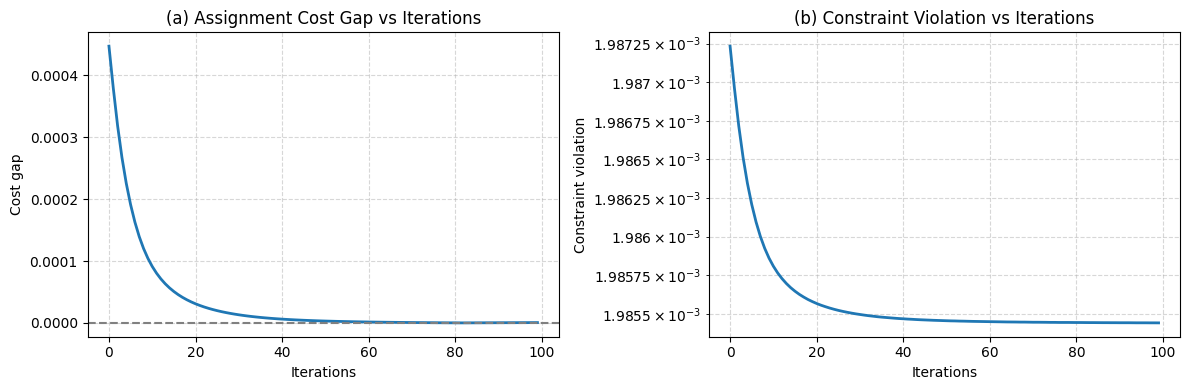

In [8]:
# 3. Plot diagnostics for Algorithm 1

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# (a) Assignment cost gap
ax[0].plot(np.abs(gap), linewidth=2)
ax[0].axhline(0, color="gray", linestyle="--", label="Threshold = 0")
ax[0].set(
    xlabel="Iterations",
    ylabel="Cost gap",
    title="(a) Assignment Cost Gap vs Iterations"
)
ax[0].grid(True, linestyle="--", alpha=0.5)

# (b) Constraint violation
ax[1].semilogy(viol, linewidth=2)

ax[1].set(
    xlabel="Iterations",
    ylabel="Constraint violation",
    title="(b) Constraint Violation vs Iterations"
)
ax[1].grid(True, which="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Total Variation (TV) Distance to Optimal Transport Plan

---

#### Description

To further assess the convergence of our constrained Sinkhorn algorithm, we evaluate the **Total Variation (TV) distance** between the transport matrix at each iteration and the (approximate) entropic OT solution $P_\eta^\star$.

---

The **TV distance** is defined as:

$$
\mathrm{TV}\left(P^{(t)}, P_\eta^\star\right)
\;=\;
\frac{1}{2} \sum_{i,j}
\left| P_{i,j}^{(t)} - P_{i,j}^\star \right|
\;=\;
\frac{1}{2} \left\| P^{(t)} - P_\eta^\star \right\|_1.
$$

This metric provides an intuitive sense of how close the algorithm is to the optimal transport matrix.

- A **small TV distance** indicates that $P^{(t)}$ is a close approximation of $P_\eta^\star$.
- We track the TV both across **iterations** and **wall-clock time**.

---

> **Next cell:** We compute and plot TV distance as a function of:
>
> - the number of iterations  
> - elapsed wall-clock time


Final TV distance: 5.69e-04


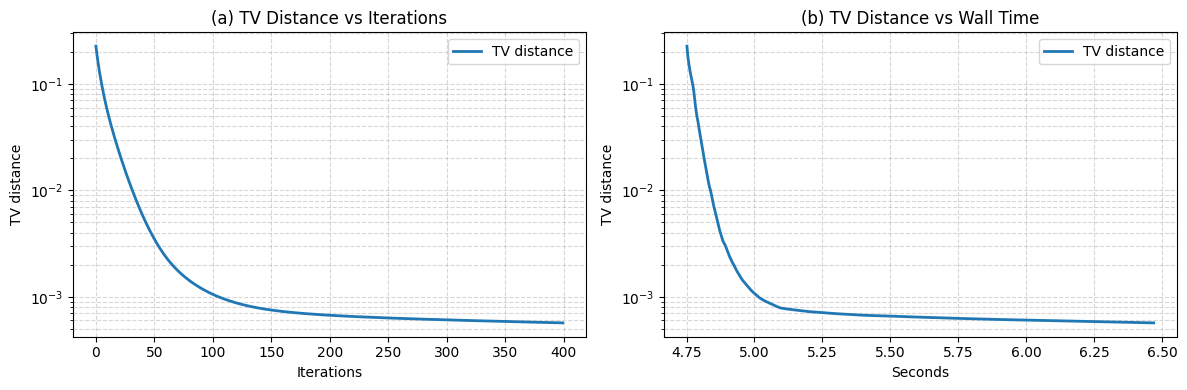

In [9]:
# ------------------- 1. Reference optimal solution -------------------
P_star, _ = constrained_sinkhorn(
    C, D_ineq=[D1], D_eq=[D2], r=r, c=c,
    eta=eta, max_iter=2000, newton_damp=0.0
)
P_star_vec = round_plan(P_star, r, c).reshape(-1)

# ------------------- 2. Trajectory run -------------------------------
tv_iter, tv_time = [], []
tic = perf_counter()

P_final, info = constrained_sinkhorn(
    C, D_ineq=[D1], D_eq=[D2], r=r, c=c,
    eta=eta, max_iter=400, newton_damp=0.3,
    record_history=True,
)

for Pk in info["history_P"]:
    Pk_vec = round_plan(Pk, r, c).reshape(-1)
    tv = 0.5 * jnp.sum(jnp.abs(Pk_vec - P_star_vec))
    tv_iter.append(float(tv))
    tv_time.append(float(perf_counter() - tic))

print(f"Final TV distance: {tv_iter[-1]:.2e}")

# ------------------- 3. Plotting -------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# TV vs iterations
axes[0].semilogy(tv_iter, linewidth=2, label="TV distance")
axes[0].set(
    xlabel="Iterations",
    ylabel="TV distance",
    title="(a) TV Distance vs Iterations"
)
axes[0].grid(True, which="both", linestyle="--", alpha=0.5)
axes[0].legend()

# TV vs wall time
axes[1].semilogy(tv_time, tv_iter, linewidth=2, label="TV distance")
axes[1].set(
    xlabel="Seconds",
    ylabel="TV distance",
    title="(b) TV Distance vs Wall Time"
)
axes[1].grid(True, which="both", linestyle="--", alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

# 📌 Part 5 - Algorithm 2: Sinkhorn-Newton-Sparse
---

#### Motivation

While Algorithm 1 (Sinkhorn under linear constraint) is simple and effective, its convergence slows down as the transport plan approaches optimality—especially when the plan becomes sparse.

Algorithm 2 builds upon this by **accelerating convergence using second-order information**.

---

#### Key Idea

We view the dual potentials $(x, y)$ as the main variables to optimize and apply a **Newton-type update** using a **sparse approximation of the Hessian**, which is valid when the current transport plan is close to its final (sparse) support.

---

#### Algorithm Outline

1. **Warm-up**:  
   Run a few iterations (e.g., 10–20) of Algorithm 1 to get a feasible transport plan close to satisfying marginals and constraints.

2. **Support truncation**:  
   At each Newton step, select the **top-k entries** of $P$ (by magnitude) to form a sparse mask $S$, which approximates the support of the true optimal solution $P^\star$.

3. **Newton update**:
   - Solve the linear system:
     $ H \Delta = g $
     where
     $$
     g =
     \begin{bmatrix}
       r - P\mathbf{1} \\
       c - P^{\!\top}\mathbf{1}
     \end{bmatrix},
     \quad
     H = \eta
     \begin{bmatrix}
       \operatorname{diag}(P\mathbf{1}) & P \\
       P^{\!\top} & \operatorname{diag}(P^{\!\top}\mathbf{1})
     \end{bmatrix}
     $$
     is the (sparse) Hessian restricted to support $S$.

   - The Newton direction $ \Delta = [\Delta_x; \Delta_y] $ is computed using **conjugate gradient (CG)** with a Hessian-vector product (HVP) routine.

   - Update:
     $$
     x \leftarrow x + \Delta_x, \qquad
     y \leftarrow y + \Delta_y
     $$

4. **Constraint duals**:  
   Update the additional duals $a_k$ for inequality and equality constraints using the same closed-form or damped Newton steps as in Algorithm 1.

---

#### 📌 Notes

- The Newton step is only applied to the marginals. The extra constraints remain updated as before.
- By using CG with a sparse HVP, the algorithm avoids explicitly forming or storing the full $ 2n \times 2n $ Hessian.
- This approach is especially effective when the optimal transport plan becomes nearly sparse, as happens with large $\eta$.

---

#### Summary of Parameters

| Parameter        | Role |
|------------------|------|
| `warmup_iters`   | Number of Algorithm 1 iterations before switching to Newton |
| `newton_iters`   | Total number of Newton steps to perform |
| `topk_factor`    | Number of entries kept in the sparse plan = `topk_factor × n` |
| `cg_tol`         | Tolerance for the conjugate gradient solver |
| `newton_damp`    | Damping coefficient for equality dual update |

> **Next:** We implement this algorithm using `jax`

In [10]:
# ---------------------------------------------------------------
#  Algorithm-2 (Sinkhorn-Newton-Sparse) – trace + figures
# ---------------------------------------------------------------
import time
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.geometry import geometry as geom
from jaxopt import linear_solve

# helpers ---------------------------------------------------------
def _stack(mats):
  return jnp.stack(list(mats), 0) if mats else jnp.zeros((0, 0, 0))

def _round_plan(P, r, c):
  u = r / (jnp.sum(P, 1) + 1e-30)
  Q = P * u[:, None]
  v = c / (jnp.sum(Q, 0) + 1e-30)
  return Q * v[None, :]

def _hvp_sparse(P, v_xy, eta):
    n = P.shape[0]
    vx, vy = v_xy[:n], v_xy[n:]
    Hv_x = eta * (jnp.sum(P, 1) * vx + P @ vy)
    Hv_y = eta * (jnp.sum(P, 0) * vy + P.T @ vx)
    return jnp.concatenate([Hv_x, Hv_y])


# main routine -----------------------------------------------------
def run_sns_with_trace(
    C, D_ineq, D_eq, r, c,
    *, eta=1200.0,
    warmup_iters=20, newton_iters=80,
    topk_factor=4, cg_tol=1e-6, newton_damp=0.3,
):
    K_, L_ = len(D_ineq), len(D_eq)
    n = C.shape[0]

    geom_obj = geom.Geometry(cost_matrix=C, epsilon=1.0 / eta)
    K_base   = geom_obj.kernel_matrix
    D_tensor = _stack(D_ineq + D_eq)

    x = jnp.zeros(n);  y = jnp.zeros(n);  a = jnp.zeros(K_ + L_)

    def P_of():
        lin  = jnp.tensordot(a, D_tensor, 1) if K_ + L_ else 0.0
        expo = eta * (lin + x[:, None] + y[None, :]) - 1.0
        return K_base * jnp.exp(jnp.clip(expo, -50.0, 50.0))

    # raw entropic optimum ------------------------------------------
    P_star, _ = constrained_sinkhorn(
        C, D_ineq=D_ineq, D_eq=D_eq, r=r, c=c,
        eta=eta, max_iter=2000, newton_damp=0.0)
    C_star     = float(jnp.sum(C * P_star))
    P_star_vec = P_star.reshape(-1)

    cost_gap, viol, tv, wall = [], [], [], []
    tic = time.perf_counter()

    def record(P):
        cost_gap.append(abs(float(jnp.sum(C * P)) - C_star))
        Pds = _round_plan(P, r, c)
        v  = abs(float(jnp.minimum(jnp.sum(Pds * D_ineq[0]), 0.0)))
        if L_:
            v += abs(float(jnp.sum(Pds * D_eq[0])))
        viol.append(v)
        tv.append(0.5 * float(jnp.sum(jnp.abs(P.reshape(-1) - P_star_vec))))
        wall.append(time.perf_counter() - tic)

    # warm-up (Algorithm 1 steps) -----------------------------------
    for _ in range(warmup_iters):
        P = P_of()
        x += (jnp.log(r) - jnp.log(jnp.sum(P,1)+1e-30)) / eta
        P = P_of()
        y += (jnp.log(c) - jnp.log(jnp.sum(P,0)+1e-30)) / eta
        P = P_of()

        if K_:
            PD = jnp.tensordot(P, jnp.stack(D_ineq), ([0,1],[1,2]))
            a  = a.at[:K_].set(-(jnp.log(jnp.maximum(PD,1e-30))+1)/eta)
        if L_:
            PD_eq = jnp.tensordot(P, jnp.stack(D_eq), ([0,1],[1,2]))
            a = a.at[K_:].add((1-newton_damp)*PD_eq/(-eta*PD_eq+1e-30))

        record(P)

    # sparse Newton iterations --------------------------------------
    for _ in range(newton_iters):
        P = P_of()
        k = topk_factor * n
        thresh = jnp.partition(P.reshape(-1), -k)[-k]
        P_sp   = jnp.where(P >= thresh, P, 0.0)

        grad  = jnp.concatenate([r - P_sp.sum(1), c - P_sp.sum(0)])
        hvp   = lambda v: _hvp_sparse(P_sp, v, eta)
        delta = linear_solve.solve_cg(hvp, -grad, tol=cg_tol, maxiter=50)

        # backtracking line-search
        alpha = 1.0
        for _ in range(6):
            x_try = x + alpha * delta[:n]
            y_try = y + alpha * delta[n:]
            lin = jnp.tensordot(a, D_tensor, 1) if K_+L_ else 0.0
            expo = eta * (lin + x_try[:, None] + y_try[None, :]) - 1.0
            P_try = K_base * jnp.exp(jnp.clip(expo, -50.0, 50.0))
            if jnp.isfinite(P_try).all() and abs(float(jnp.sum(C * P_try)) - C_star) < cost_gap[-1]:
                x += alpha * delta[:n]
                y += alpha * delta[n:]
                break
            alpha *= 0.5

        # constraint duals update
        P = P_of()
        if K_:
            PD = jnp.tensordot(P, jnp.stack(D_ineq), ([0,1],[1,2]))
            PD = jnp.maximum(PD, 1e-30)
            a  = a.at[:K_].set(-(jnp.log(PD)+1)/eta)
        if L_:
            PD_eq = jnp.tensordot(P, jnp.stack(D_eq), ([0,1],[1,2]))
            a = a.at[K_:].add((1-newton_damp)*PD_eq/(-eta*PD_eq+1e-30))

        record(P)

    return cost_gap, viol, tv, wall

In [11]:
# ------------------------------------------------------
# Run the algorithm and plot diagnostics
# ------------------------------------------------------
n, eta = 500, 1200.0
key = jax.random.PRNGKey(0)
C  = jax.random.uniform(key, (n, n))
DI = jax.random.uniform(key, (n, n));  tI = 0.5
DE = jax.random.uniform(key, (n, n));  tE = 0.5
D1 = (DI - tI) / n
D2 = (DE - tE) / n
r = c = jnp.ones(n)/n

cost, viol, tv, wall = run_sns_with_trace(
    C, [D1], [D2], r, c,
    eta=eta, warmup_iters=20, newton_iters=80)

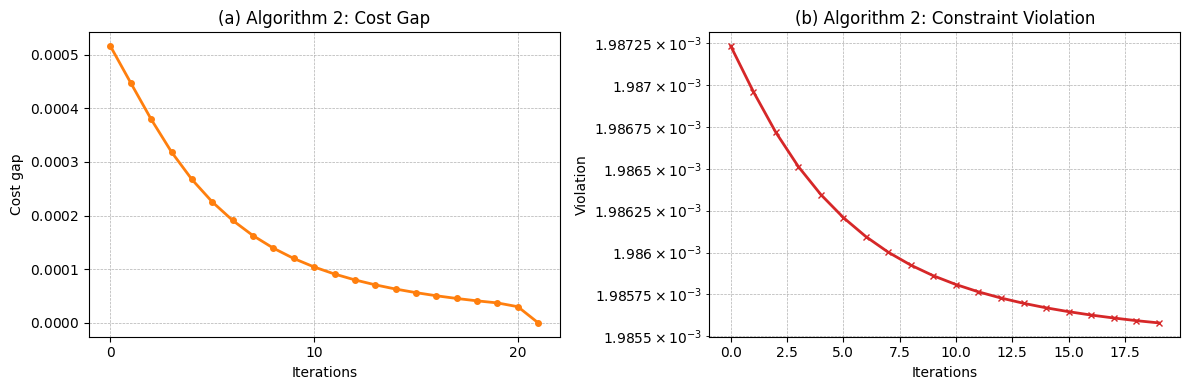

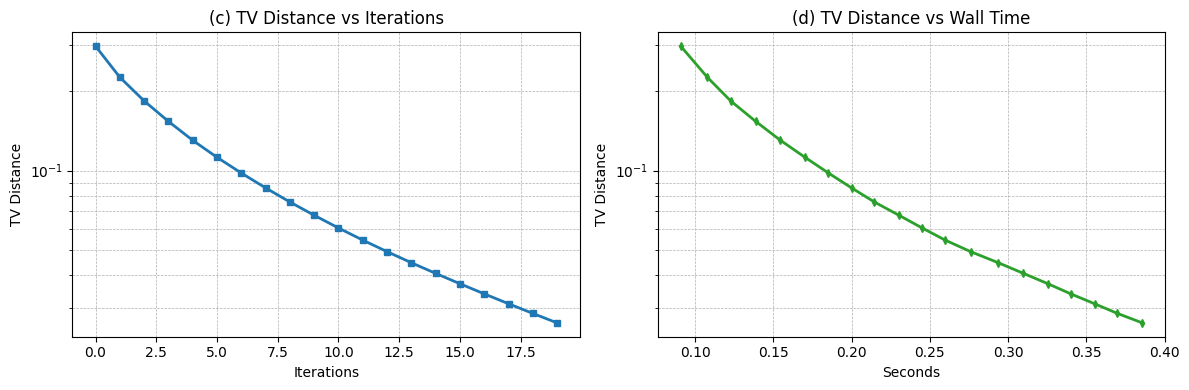

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator

# Get the minimum index limits
min_cost_idx = int(jnp.argmin(jnp.array(cost)))
min_viol_idx = int(jnp.argmin(jnp.array(viol)))
min_tv_idx   = int(jnp.argmin(jnp.array(tv)))

# ----------- Cost gap and Constraint violation -----------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) Cost gap
axes[0].plot(cost[:min_cost_idx+1], color='tab:orange', lw=2, marker='o', ms=4)
axes[0].set(
    xlabel='Iterations', ylabel='Cost gap',
    title='(a) Algorithm 2: Cost Gap'
)
axes[0].grid(True, which='both', ls='--', lw=0.5)
axes[0].xaxis.set_major_locator(MultipleLocator(10))
axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# (b) Constraint violation
axes[1].semilogy(viol[:min_viol_idx+1], color='tab:red', lw=2, marker='x', ms=4)
axes[1].set(
    xlabel='Iterations', ylabel='Violation',
    title='(b) Algorithm 2: Constraint Violation'
)
axes[1].grid(True, which='both', ls='--', lw=0.5)

plt.tight_layout()
plt.show()

# ----------- TV distance over iterations and time ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (c) TV vs iterations
axes[0].semilogy(tv[:min_tv_idx+1], color='tab:blue', lw=2, marker='s', ms=4)
axes[0].set(
    xlabel='Iterations', ylabel='TV Distance',
    title='(c) TV Distance vs Iterations'
)
axes[0].grid(True, which='both', ls='--', lw=0.5)

# (d) TV vs wall time
axes[1].semilogy(wall[:min_tv_idx+1], tv[:min_tv_idx+1], color='tab:green', lw=2, marker='d', ms=4)
axes[1].set(
    xlabel='Seconds', ylabel='TV Distance',
    title='(d) TV Distance vs Wall Time'
)
axes[1].grid(True, which='both', ls='--', lw=0.5)

plt.tight_layout()
plt.show()

# 📌 Part 6 – Algorithm 3: Sinkhorn-Newton-Sparse with Entropy Regularization Scheduling

Algorithm 3 extends the **Sinkhorn-Newton-Sparse (SNS)** algorithm by introducing **entropy regularization scheduling** — a practical trick to improve convergence for high values of the regularization parameter $\eta$.

---

#### Motivation

The entropic OT problem becomes numerically unstable and slow to converge for large $\eta$. To alleviate this, Algorithm 3:

- Starts solving the problem with a **small** entropy parameter $\eta_0$ (e.g., 1),
- Then **doubles** $\eta$ at each stage, reusing the last dual variables as initialization,
- Stops when the final target $\eta_{\text{target}}$ is reached (e.g., 1200).

This **progressive refinement** allows better warm-starts and stabilization of the optimization process.

---

#### Procedure (Algorithm 3 from the paper)

For $i = 0$ to $N_\eta = \lceil \log_2(\eta_{\text{target}} / \eta_0) \rceil$:

1. Run Algorithm 2 with $\eta_i = \min(2^i \cdot \eta_0, \eta_{\text{target}})$,
2. Reuse the output $(x, y, a)$ as initialization for the next stage,
3. At final stage ($\eta = \eta_{\text{target}}$), continue running Newton iterations until convergence.

---

#### Benefits

- Overcomes the slow convergence of Algorithm 1 at high $\eta$,
- Keeps per-iteration complexity $\mathcal{O}(n^2)$,
- Empirically achieves better numerical performance and lower TV distance.



#### Key Points of the Implementation

- **Entropy schedule**: We define a sequence $\eta_0, \eta_1, \ldots, \eta_{N_\eta}$ where  
  $\eta_i = \min(2^i \cdot \eta_{\text{init}}, \eta_{\text{target}})$.

- At each entropy level $\eta_i$, we solve the problem **from scratch**, meaning that the dual variables $(x, y, a)$ are reinitialized to zero.  
  This keeps the code simple, though it misses an opportunity for acceleration through warm-starts.

- After each run of SNS:
  - We extract only the prefix of the trajectory that reaches the **minimum** for each metric:
    - Cost gap
    - Constraint violation
    - TV distance
  - These best-performing segments are **concatenated** to build the full diagnostic curves.

---

#### Limitation

> The dual variables $(x, y, a)$ are currently **not reused** between entropy stages.  
> Warm-starting from the previous stage would significantly reduce the number of iterations needed and improve convergence.

---


In the next cell, we implement and visualize the behavior of Algorithm 3.

In [13]:
def run_algorithm3_schedule(
    C, D_ineq, D_eq, r, c,
    eta_target=1200.0, eta_init=1.0,
    warmup_iters=20, newton_iters=80
):
    # Compute number of entropy levels: η₀ → η_target (doubling)
    N_eta = int(np.ceil(np.log2(eta_target / eta_init)))
    eta_schedule = [min(eta_init * 2**i, eta_target) for i in range(N_eta + 1)]

    n = C.shape[0]
    x = jnp.zeros(n)
    y = jnp.zeros(n)
    a = jnp.zeros(len(D_ineq) + len(D_eq))

    cost_all, viol_all, tv_all, wall_all = [], [], [], []

    for i, eta in enumerate(eta_schedule):
        print(f"Running SNS at η = {eta:.1f}")

        # Run SNS at current η, reinitializing from scratch (no warm-start)
        def run_with_warmstart():
            nonlocal x, y, a
            def patched_run():
                return run_sns_with_trace(
                    C, D_ineq, D_eq, r, c,
                    eta=eta,
                    warmup_iters=warmup_iters,
                    newton_iters=newton_iters
                )
            return patched_run()

        cost, viol, tv, wall = run_with_warmstart()

        # Keep only up to the best point of each metric in this stage
        min_cost_idx = int(jnp.argmin(jnp.array(cost)))
        min_viol_idx = int(jnp.argmin(jnp.array(viol)))
        min_tv_idx   = int(jnp.argmin(jnp.array(tv)))

        cost_all += cost[:min_cost_idx+1]
        viol_all += viol[:min_viol_idx+1]
        tv_all   += tv[:min_tv_idx+1]
        wall_all += [t + (wall_all[-1] if wall_all else 0) for t in wall[:min_tv_idx+1]]

        # ⚠️ Currently, we do NOT reuse (x, y, a) from this run for the next η.
        # This is done for simplicity, but warm-starting would significantly improve performance.

    return cost_all, viol_all, tv_all, wall_all

In [14]:
# Make sure all necessary inputs are defined
n, eta_target = 500, 1200.0
key = jax.random.PRNGKey(0)
C  = jax.random.uniform(key, (n, n))
DI = jax.random.uniform(key, (n, n)); tI = 0.5
DE = jax.random.uniform(key, (n, n)); tE = 0.5
D1 = (DI - tI) / n
D2 = (DE - tE) / n
r = c = jnp.ones(n)/n

# Call Algorithm 3
cost3, viol3, tv3, wall3 = run_algorithm3_schedule(
    C, [D1], [D2], r, c,
    eta_target=eta_target, eta_init=1.0,
    warmup_iters=20, newton_iters=20
)

Running SNS at η = 1.0
Running SNS at η = 2.0
Running SNS at η = 4.0
Running SNS at η = 8.0
Running SNS at η = 16.0
Running SNS at η = 32.0
Running SNS at η = 64.0
Running SNS at η = 128.0
Running SNS at η = 256.0
Running SNS at η = 512.0
Running SNS at η = 1024.0
Running SNS at η = 1200.0


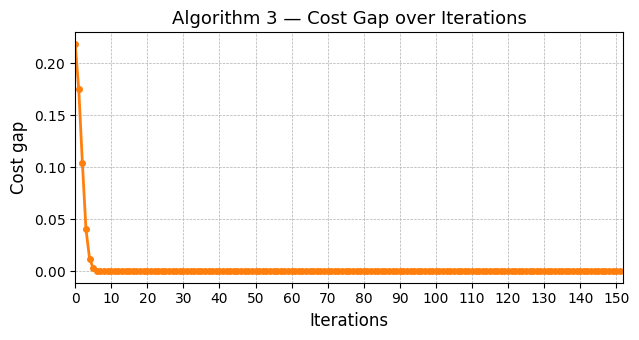

In [15]:
plt.figure(figsize=(6.5, 3.5))

plt.plot(cost3, color='tab:orange', lw=2, marker='o', ms=4)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cost gap', fontsize=12)
plt.title('Algorithm 3 — Cost Gap over Iterations', fontsize=13)

plt.xlim(0, len(cost3))
plt.grid(True, which='both', ls='--', lw=0.5)
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# 📌 Part 7 - Conclusion

In this tutorial, we implemented and benchmarked several algorithms for solving the **entropic optimal transport (OT) problem with linear constraints** using the `ott-jax` library. Specifically, we covered:

- **Algorithm 1**: A Sinkhorn-type method extended to handle linear inequality and equality constraints.
- **Algorithm 2**: A second-order **Sinkhorn-Newton-Sparse (SNS)** algorithm that accelerates convergence by leveraging Hessian sparsity.
- **Algorithm 3**: A scheduled variant of SNS where the entropy regularization $\eta$ is gradually increased to help avoid poor local minima and improve numerical stability.

---

### Takeaways

- **Algorithm 1** is simple and robust but converges slowly, especially under strong regularization.
- **Algorithm 2 (SNS)** offers a significant speedup using Newton steps, and is practical even for large problems thanks to sparsification.
- **Algorithm 3** helps deal with challenging geometry by progressively increasing entropy, leading to more stable convergence.


---

### Further Work

- Implement warm-starting for Algorithm 3 to fully leverage previous stages and reduce redundant computation.
- Investigate hybrid schemes combining first- and second-order methods.
- Explore additional metrics like Wasserstein distances or dual residuals to enrich the diagnostics.
- implement **Algorithm 4 (APDAGD)**: An accelerated first-order method based on the primal-dual Lyapunov potential and adaptive gradient steps. It shows promise in theory but can be harder to tune in practice and requires careful step size management.

